In [14]:
'''
Written by rizawa
Written on 2018-06-08
'''

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import psycopg2
import json
import os
import re
from datetime import date
from datetime import datetime

with open('/Users/rizawa/Code/config/settings.json') as config_file:
    config = json.load(config_file)


CONNECTION_PARAMETERS = config['dbs']

HOST = CONNECTION_PARAMETERS['hostname']
USER = CONNECTION_PARAMETERS['username']
WORD = CONNECTION_PARAMETERS['password']
DTBS = CONNECTION_PARAMETERS['database']
PORT = CONNECTION_PARAMETERS['port']


def execute_query(query):
    connection = psycopg2.connect(host=HOST,user=USER,password=WORD,dbname=DTBS,port=PORT)
    cur = connection.cursor()
    cur.execute(query)
    column_list = [c[0] for c in cur.description]
    df_query = pd.DataFrame(cur.fetchall(), columns=column_list)
    connection.close()
    return df_query

In [15]:
def query_edges(incl=0,excl=0):
    
    query_str = """
    select distinct
    events.account_id as a
    ,guests.account_id as b
    ,count(*) as bond
    from paperless_public.events
    join paperless_public.guests on events.id = guests.event_id 
    where events.account_id != guests.account_id
    and guests.sent_at is not null
    and events.account_id in (""" + str(incl) + """)
    and guests.account_id not in (""" + str(excl) + """)
    group by 1,2

    union

    select distinct
    guests.account_id as a
    ,events.account_id as b
    ,count(*) as bond
    from paperless_public.events
    join paperless_public.guests on events.id = guests.event_id 
    where events.account_id != guests.account_id
    and guests.sent_at is not null
    and guests.account_id in (""" + str(incl) + """)
    and events.account_id not in (""" + str(excl) + """)
    group by 1,2
    ;
    """
    return query_str

In [16]:
def query_paths(incl=0):
    query_str = """
    SELECT
        guests.account_id as a
        ,events.account_id as b
        ,count(*) as bond
    FROM guests
    JOIN events ON events.id = guests.event_id
    WHERE guests.sent_at IS NOT null
    AND guests.account_id IN (""" + incl + """)
    AND events.account_id IN (""" + incl + """)
    GROUP BY 1,2
    ;
    """
    return query_str

In [17]:
def query_accounts(incl=0):
    query_str = """
    SELECT
    accounts.id
    ,accounts.display_name
    ,email.email_address
    FROM accounts
    JOIN email_addresses email ON email.account_id = accounts.id
    WHERE accounts.id IN (""" + incl + """)
    AND email.primary IS true
    ;
    """
    return query_str

In [18]:
acct0 = 0; acct1 = 2

In [42]:
def query_first_group():
    str_query = """
    select
    """ + str(acct0) + """ as a
    ,accounts.id as b
    ,1 as bond
    from paperless_public.accounts
    join paperless_public.email_addresses email on accounts.id = email.account_id
    where email.email_address like '%.ir'
    and email.primary is true
    ;
    """
    return str_query

In [43]:
def query_second_group():
    str_query = """
    select
    """ + str(acct1) + """ as a
    ,accounts.id as b
    ,1 as bond
    from paperless_public.accounts
    join paperless_public.email_addresses email on accounts.id = email.account_id
    where email.email_address like '%gov.sa'
    and email.primary is true
    ;
    """
    return str_query

In [44]:
first_query = query_first_group()
first_group = execute_query(first_query)

second_query = query_second_group()
second_group = execute_query(second_query)

In [45]:
print(len(first_group))
print(len(second_group))

176
62


In [46]:
def find_path(edges_x, edges_y):

    common_nodes = set(edges_x['b']) & set(edges_y['b'])
    
    if not common_nodes:

        incl = ",".join(str(e) for e in edges_x['b'])
        excl = ",".join(str(e) for e in edges_x['a'])
        str_query = query_edges(incl,excl)
        edges_q = execute_query(str_query)
        
        incl = ",".join(str(e) for e in edges_y['b'])
        excl = ",".join(str(e) for e in edges_y['a'])
        str_query = query_edges(incl,excl)
        edges_r = execute_query(str_query)
        
        beam = find_path(edges_q, edges_r)
        # Merge and rename the columns so they can be merged later
        fore = pd.merge(edges_x[['a','b']], beam, on='b', how='inner')
        cols = ['a']
        for c in range(2,len(fore.columns)):
            cols.append(c)
        cols.append('b')
        fore.columns = cols
        # Merge and rename the columns so they can be merged later
        ship = pd.merge(fore, edges_y[['a','b']], on='b', how='inner')
        cols = ['b']
        for c in range(2,len(ship.columns)):
            cols.append(c)
        cols.append('a')
        ship.columns = cols
        
    else:
        
        ship = pd.merge(edges_x, edges_y, on='b', how='inner')[['a_x','b','a_y']]
        ship.columns = ['b','x','a']

    paths = ship
    return paths

In [47]:
start_time = datetime.now()

paths = find_path(first_group, second_group)
# Renaming the columns for ease of use.
cols = []
for c in range(0,len(paths.columns)):
    cols.append(c)
paths.columns = cols

# Reducing the accounts to unique account_ids,
# then querying all edges involving these accounts.
unique_accounts = pd.unique(paths.values.ravel('K'))
str_acct = ",".join(str(e) for e in unique_accounts)
str_query = query_paths(str_acct)
real_paths = execute_query(str_query)
list_paths = [first_group, second_group, real_paths]
all_paths = pd.concat(list_paths)

# Building the graph from the queried edges.
G = nx.from_pandas_edgelist(all_paths, 'a', 'b', ['bond'])

print('completed in: ' + str(datetime.now() - start_time))

completed in: 0:00:05.479791


In [48]:
start_time = datetime.now()

for path in nx.all_simple_paths(G, source=acct0, target=acct1, cutoff=6):
    print(path)

#for path in nx.shortest_path(G, source=acct0, target=acct1):
#    print(path)

print('completed in: ' + str(datetime.now() - start_time))

[0, 15761773, 957281, 15751062, 2]
[0, 15761773, 957281, 15762051, 2]
[0, 15761773, 957281, 15760747, 2]
[0, 15759770, 957281, 15751062, 2]
[0, 15759770, 957281, 15762051, 2]
[0, 15759770, 957281, 15760747, 2]
[0, 22076998, 149860, 27426393, 2]
[0, 22076998, 149860, 29797816, 2]
[0, 8879976, 153316, 8873821, 2]
[0, 8879976, 153316, 8879970, 2]
[0, 8879976, 153316, 8879970, 1671019, 21852648, 2]
[0, 8879976, 153316, 8879970, 1671019, 21859285, 2]
[0, 8879976, 153316, 8879970, 1671019, 21857687, 2]
[0, 8879976, 153316, 8879970, 1671019, 21859007, 2]
[0, 8879976, 153316, 8879970, 1671019, 21853028, 2]
[0, 8879976, 153316, 8879970, 1671019, 1678193, 2]
[0, 8879976, 153316, 8879970, 1671019, 21854890, 2]
[0, 8879976, 153316, 8879970, 1671019, 3634752, 2]
[0, 8879976, 153316, 8879970, 1671019, 21857522, 2]
[0, 8879976, 153316, 8879970, 1671019, 21857338, 2]
[0, 8879976, 153316, 8879970, 1671019, 21854138, 2]
[0, 8879976, 153316, 8873647, 2]
[0, 15758751, 957281, 15751062, 2]
[0, 15758751, 95

completed in: 0:00:00.875433


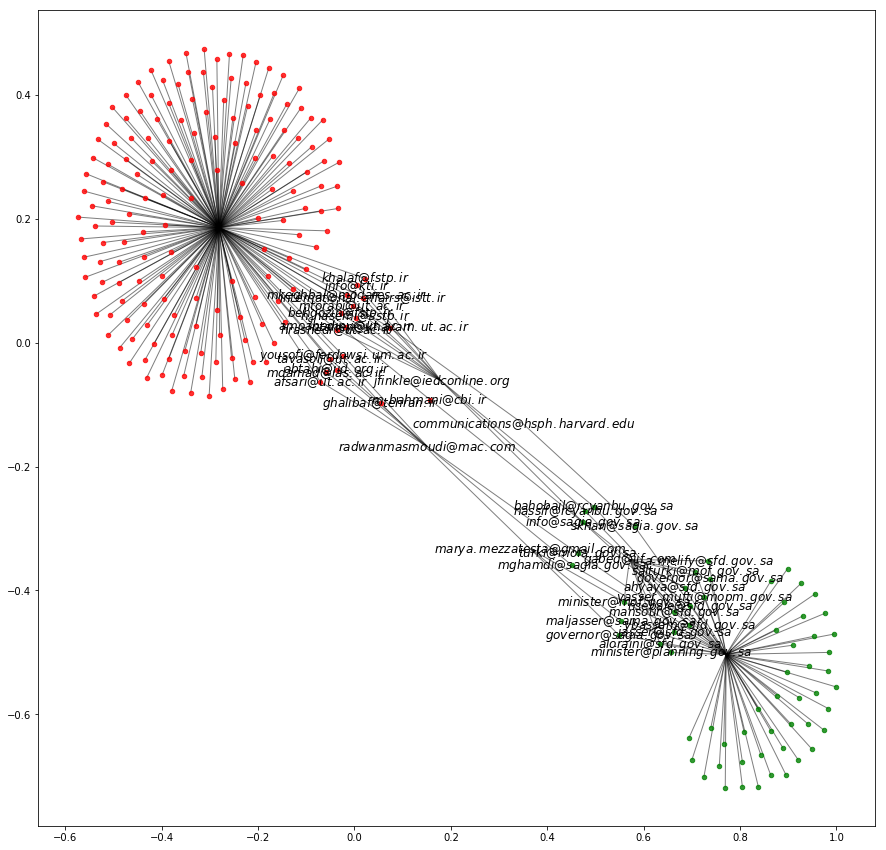

In [49]:
# All paths within threshold
start_time = datetime.now()

pos = nx.spring_layout(G)
plt.figure(1,figsize=(15,15))
plt.subplot(111)

# node lists
first_nodes = list(first_group['b'])
second_nodes = list(second_group['b'])

# nodes
nx.draw_networkx_nodes(G,pos,nodelist=first_nodes,node_color='r',node_size=20,alpha=0.8)
nx.draw_networkx_nodes(G,pos,nodelist=second_nodes,node_color='g',node_size=20,alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)


# Create the networkx diagram labels from the list of emails.
str_query = query_accounts(str_acct)
all_accounts = execute_query(str_query)
emails = all_accounts['email_address']

labels = {}
for idx,val in enumerate(all_accounts['id']):
    labels[val] = r'$'+emails[idx]+'$'
# Draw the labels
nx.draw_networkx_labels(G,pos,labels)

print('completed in: ' + str(datetime.now() - start_time))